In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import utils
from torchvision.transforms import v2 as transforms
from torchvision import models
from torchvision.models import ResNet18_Weights, ResNet50_Weights
from PIL import Image
import pandas as pd
import os
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from torchvision.io.image import decode_jpeg, read_file
import matplotlib.pyplot as plt
import torchvision.utils as vutils

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Data Loaders

### Dataset for Returning Image and Class

In [3]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None, binary=True):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform
        self.binary = binary

       # Add a 'label' column to the DataFrame
        if self.binary:
            self.data['label'] = self.data['real_age'].apply(lambda age: 0 if age < 25 else 1)
            self.classes = self.data['label'].unique().tolist()
        else:
            self.data['label'] = self.data['real_age']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row['file_name'])+'_face.jpg'
        label = row['label']

        # Load image
        #image = Image.open(img_path).convert('RGB')  # Load RGB
        image = decode_jpeg(read_file(img_path), device="cpu").to('cuda')
        image = image.float() / 255.0 
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label

### Transformations for Data Augmentation and Normalisation

In [4]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8,1)),
    transforms.GaussianBlur(kernel_size=3.0, sigma=(0.1, 1)),
    #transforms.GaussianNoise(mean=0, sigma=0.1, clip=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

### Create Dataset from CSV

In [5]:
train_csv = 'appa-real-release/cropped_train.csv'
val_csv = 'appa-real-release/cropped_valid.csv'
test_csv = 'appa-real-release/cropped_test.csv'

train_dir = 'appa-real-release/cropped_train'
val_dir = 'appa-real-release/cropped_valid'
test_dir = 'appa-real-release/cropped_test'


# Create datasets
train_dataset = CustomDataset(csv_file=train_csv, image_dir=train_dir, transform=train_transforms, binary=True)
val_dataset = CustomDataset(csv_file=val_csv, image_dir=val_dir, transform=val_transforms, binary=True)
test_dataset = CustomDataset(csv_file=test_csv, image_dir=test_dir, transform=test_transforms, binary=True)

In [6]:
print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Val Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

print(f"Classes: {train_dataset.classes}. 0<25yo | 1>=25yo")


Train Dataset Size: 3920
Val Dataset Size: 1438
Test Dataset Size: 1828
Classes: [0, 1]. 0<25yo | 1>=25yo


### Stratification

In [7]:
# Compute class weights
class_counts = train_dataset.data['label'].value_counts()
class_weights = 1.0 / class_counts
sample_weights = train_dataset.data['label'].map(class_weights)

# Create sampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

### Creating Loaders

In [8]:
# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    sampler=sampler
)
val_loader = DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False
)

### Display Batches

Images batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])
Image Classes: tensor([1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
        1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
Class 1 Images: 37
Class 0 Images: 27


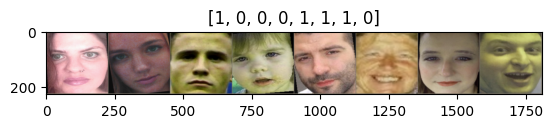

In [9]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = vutils.make_grid(inp)  
    inp = inp.permute(1, 2, 0) 
    
    # Convert mean and std to PyTorch tensors
    mean = torch.tensor([0.485, 0.456, 0.406], device=inp.device)
    std = torch.tensor([0.229, 0.224, 0.225], device=inp.device)
    
    # Normalize the image
    inp = std * inp + mean
    inp = torch.clamp(inp, 0, 1)  # Ensure values are within [0, 1]
    
    # Convert the tensor to a NumPy array for visualization
    inp = inp.cpu().numpy()

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get one batch of data
data_iter = iter(train_loader)  
images, labels = next(data_iter) 
images, labels = images.to(device), labels.to(device)

print(f"Images batch shape: {images.shape}")
print(f"Labels batch shape: {labels.shape}")
print(f"Image Classes: {labels}")

print(f"Class 1 Images: {torch.sum(labels)}")
print(f"Class 0 Images: {len(labels) - torch.sum(labels)}")

n = 8

# Make a grid from batch
out = images[:n]  # Take the first 'n' images

imshow(out, title=[x.item() for x in labels[:n]])


# Model Training

## Using Pytorch pretrained ResNet model - trained on ImageNet

In [10]:
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
num_features = model.fc.in_features 
print(f"Number of features from pre-trained model {num_features}")

# This is just for logging during training
if num_features == 512:
    resnet_arch = 'ResNet18'
elif num_features ==2048:
    resnet_arch = 'ResNet50'
else:
    resnet_arch = 'other'

Number of features from pre-trained model 2048


### Add a fully connected layer
- Freeze weights for existing parameters of pretrained model
    - These dont need retrained since we are doing transfer learning
- Add a fully connected linear layer
    - This maps from the output of the pretrained model (512 for ResNet-18 / 2048 for ResNet-50)
    - To the output we want for our classifier (1 - the probability of being a certain class)
- The weights in this layer will be trained to fit our data

In [11]:
train_on_l4 = False
# Freeze the layers in the pre-trained model
for param in model.parameters():
    param.requires_grad = False
    
# Unfreeze all residual blocks in the fourth layer
# For resnet-18 that is 2 blocks, for resnet50 that is 3 blocks
for name, param in model.layer4.named_parameters(): 
    print(name)
    param.requires_grad = True
    train_on_l4 = True
    
# Add a fully connected linear layer which transforms from 512 nodes -> 1 node
# Note that we dont add a sigmoid activation function here because we use nn.BCEWithLogitsLoss(), which applies sigmoid while calculating loss
model.fc = nn.Linear(num_features, 1)

for param in model.fc.parameters():
    param.requires_grad = True


# This is just to store a string for saving the model after training
if train_on_l4:
    train_type = 'fc+layer4'
else:
    train_type = 'fc'

print(train_type)
print(resnet_arch)

0.conv1.weight
0.bn1.weight
0.bn1.bias
0.conv2.weight
0.bn2.weight
0.bn2.bias
0.conv3.weight
0.bn3.weight
0.bn3.bias
0.downsample.0.weight
0.downsample.1.weight
0.downsample.1.bias
1.conv1.weight
1.bn1.weight
1.bn1.bias
1.conv2.weight
1.bn2.weight
1.bn2.bias
1.conv3.weight
1.bn3.weight
1.bn3.bias
2.conv1.weight
2.bn1.weight
2.bn1.bias
2.conv2.weight
2.bn2.weight
2.bn2.bias
2.conv3.weight
2.bn3.weight
2.bn3.bias
fc+layer4
ResNet50


In [12]:
print(f"Number of Learnable Parameters:  {sum([param.numel() for param in model.layer4.parameters() if param.requires_grad==True]) + sum([param.numel() for param in model.fc.parameters()])}")

Number of Learnable Parameters:  14966785


### Train and Test functions

In [13]:
def train(model, device, train_loader, optimizer, criterion, epoch, writer):

    model.train()
    epoch_loss = 0 # Keep track of total loss over this epoch
    
    for batch_idx, (data, target) in enumerate(train_loader):

        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        
        # Forward Pass
        output = model(data)

        # Compute Loss
        # Squeeze output: (32, 1) -> (32,) to match target shape (32,)
        # Convert target to float: Targets are integers 0,1. Loss function expects float
        loss = criterion(output.squeeze(), target.float()) 
        epoch_loss += loss.item()
        
        # Backwards pass and optimisation
        loss.backward()
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    writer.add_scalar('Train', epoch_loss / len(train_loader), epoch)

In [14]:
def val(model, device, val_loader, criterion, epoch, writer):
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            # Compute loss
            val_loss += criterion(output.squeeze(), target.float()).item()  # Sum up batch loss
            
            # # Apply sigmoid to logits to get probabilities
            output = torch.sigmoid(output)
            
            # Get predictions by thresholding at 0.5
            pred = (output > 0.5).float()  # Convert probabilities to 0 or 1
            
            # Update correct count (compare predictions to target)
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Average the val loss over the entire dataset
    val_loss /= len(val_loader)
    
    # Print results
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    
    writer.add_scalars('Val', {
        'Loss': val_loss,
        'Accuracy': correct / len(val_loader.dataset)
    }, epoch)
    return val_loss

In [15]:
%reload_ext tensorboard

In [16]:
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1)

# optimizer = optim.SGD(model.parameters(), lr=0.001)

now = datetime.now()
log_dir = "./logs/" + now.strftime("%Y%m%d-%H%M%S-") + resnet_arch + "/"
writer = SummaryWriter(log_dir=log_dir, comment='Training Logs')

for epoch in range(1, 50 + 1):
    train(model, device, train_loader, optimizer, criterion, epoch, writer)
    val_loss = val(model, device, val_loader, criterion, epoch, writer)
    #scheduler.step(val_loss)

writer.close()

Train Epoch: 1 [0/3920 (0%)]	Loss: 0.700173
Train Epoch: 1 [640/3920 (16%)]	Loss: 0.591864
Train Epoch: 1 [1280/3920 (32%)]	Loss: 0.582106
Train Epoch: 1 [1920/3920 (48%)]	Loss: 0.608857
Train Epoch: 1 [2560/3920 (65%)]	Loss: 0.623538
Train Epoch: 1 [3200/3920 (81%)]	Loss: 0.557569
Train Epoch: 1 [3840/3920 (97%)]	Loss: 0.504403

Validation set: Average loss: 0.6359, Accuracy: 1035/1438 (72%)

Train Epoch: 2 [0/3920 (0%)]	Loss: 0.573387
Train Epoch: 2 [640/3920 (16%)]	Loss: 0.525631
Train Epoch: 2 [1280/3920 (32%)]	Loss: 0.455609
Train Epoch: 2 [1920/3920 (48%)]	Loss: 0.430810
Train Epoch: 2 [2560/3920 (65%)]	Loss: 0.450800
Train Epoch: 2 [3200/3920 (81%)]	Loss: 0.445740
Train Epoch: 2 [3840/3920 (97%)]	Loss: 0.506627

Validation set: Average loss: 0.5127, Accuracy: 1095/1438 (76%)

Train Epoch: 3 [0/3920 (0%)]	Loss: 0.465863
Train Epoch: 3 [640/3920 (16%)]	Loss: 0.423330
Train Epoch: 3 [1280/3920 (32%)]	Loss: 0.648178
Train Epoch: 3 [1920/3920 (48%)]	Loss: 0.392471
Train Epoch: 3 [256

In [17]:
torch.save(model.state_dict(), "./models/"  + resnet_arch +"_" +train_type + "_" + now.strftime("%Y-%m-%d") + ".pth")
print("Saved model to ./models/"  + resnet_arch +"_" +train_type + "_" + now.strftime("%Y-%m-%d") + ".pth")

Saved model to ./models/ResNet50_fc+layer4_2025-01-22.pth


In [19]:
%tensorboard --logdir=./logs/ --host localhost --port 6007

# Test Evaluation

In [20]:
def test(model, device, test_loader, criterion):
    model.eval()  # Set model to evaluation mode
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            # Compute loss
            output = model(data)       
            test_loss += criterion(output.squeeze(), target.float()).item()  # Sum up batch loss
            
            # # Apply sigmoid to logits to get probabilities
            output = torch.sigmoid(output)
            
            # Get predictions by thresholding at 0.5
            pred = (output > 0.5).float()  # Convert probabilities to 0 or 1
            
            # Update correct count (compare predictions to target)
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Average the val loss over the entire dataset
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    
    return test_loss, test_accuracy

In [21]:
test_loss, test_accuracy = test(model, device, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.8204, Test Accuracy: 80.9628


# Visualise Predictions

In [26]:
def visualize_model(model, num_images=6, show_fails=False):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            output = model(inputs)
            
            # # Apply sigmoid to logits to get probabilities
            output = torch.sigmoid(output)
            
            # Get predictions by thresholding at 0.5
            pred = (output > 0.5).float()  # Convert probabilities to 0 or 1

            for j in range(inputs.size()[0]):
                # Check if prediction matches the label
                is_misclassified = pred[j].item() != labels[j].item()

                # Skip correctly classified cases if show_fails is True
                if show_fails and not is_misclassified:
                    continue
                    
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {pred[j].item()}. Ground Truth: {labels[j].item()}.')
                print(f'Confidence / Model Output: {output[j].item():.3f}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

0/1 - High confidence, ~0.5 - Low confidence
Confidence / Model Output: 0.811


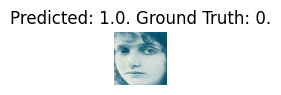

Confidence / Model Output: 1.000


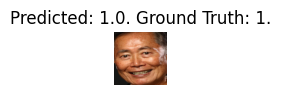

Confidence / Model Output: 1.000


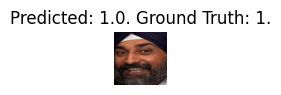

Confidence / Model Output: 0.001


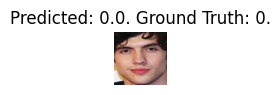

Confidence / Model Output: 1.000


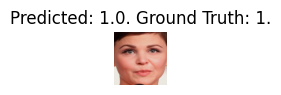

Confidence / Model Output: 0.990


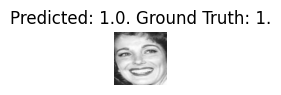

Confidence / Model Output: 0.999


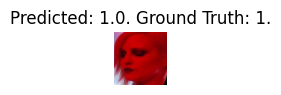

Confidence / Model Output: 1.000


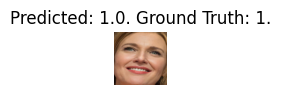

Confidence / Model Output: 0.983


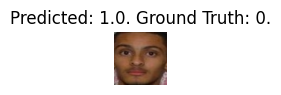

Confidence / Model Output: 0.993


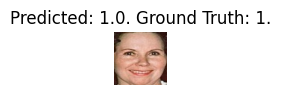

Confidence / Model Output: 1.000


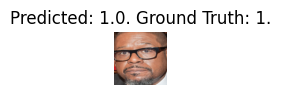

Confidence / Model Output: 1.000


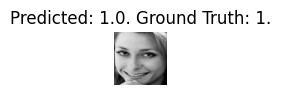

In [31]:
print('0/1 - High confidence, ~0.5 - Low confidence')
print('='*50)
visualize_model(model, num_images=12, show_fails=False)